## CLIP model with Jina CLIP and OpenVINO

[jina-clip-v1](https://huggingface.co/jinaai/jina-clip-v1) is a state-of-the-art English multimodal(text-image) embedding model trained by [Jina AI](https://aimodels.fyi/creators/huggingFace/jinaai). It bridges the gap between traditional text embedding models, which excel in text-to-text retrieval but are incapable of cross-modal tasks, and models that effectively align image and text embeddings but are not optimized for text-to-text retrieval. jina-clip-v1 offers robust performance in both domains. Its dual capability makes it an excellent tool for multimodal retrieval-augmented generation (MuRAG) applications, allowing seamless text-to-text and text-to-image searches within a single model. jina-clip-v1 can be used for a variety of multimodal applications, such as: image search by describing them in text, multimodal question answering, multimodal content generation. Jina AI has also provided the Embeddings API as an easy-to-use interface for working with jina-clip-v1 and their other embedding models.

In this notebook we will load the model with Hugging Face Transformers, convert it to OpenVINO IR format, optimize it with NNCF and show the life demo.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Prepare input data](#Prepare-input-data)
    - [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Prepare input data](#Prepare-input-data)
    - [Convert Model to OpenVINO IR format](#Convert-Model-to-OpenVINO-IR-format)
    - [Select inference device](#Select-inference-device)
    - [Compile model and run inference](#Compile-model-and-run-inference)
- [Quantize model to INT8 using NNCF](#Quantize-model-to-INT8-using-NNCF)
    - [Prepare datasets](#Prepare-datasets)
        - [Dataset with text data](#Dataset-with-text-data)
        - [Dataset with image data](#Dataset-with-image-data)
    - [Perform quantization](#Perform-quantization)
        - [Quantization of text model](#Quantization-of-text-model)
        - [Quantization of image model](#Quantization-of-image-model)
    - [Compare File Size](#Compare-File-Size)
    - [Compare inference time of the FP16 IR and quantized models](#Compare-inference-time-of-the-FP16-IR-and-quantized-models)
- [Gradio demo](#Gradio-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/jina-clip/jina-clip.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform

%pip install -q "openvino>=2024.6.0" "datasets>=2.20" "nncf>=2.14.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "gradio>=4.19" "pillow" "einops" "timm" "transformers[torch]>=4.39" "torch>=2.1" "matplotlib>=3.4" "typing_extensions>=4.9"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

## Instantiate model
[back to top ⬆️](#Table-of-contents:)


Let's load the [jinaai/jina-clip-v1](https://huggingface.co/jinaai/jina-clip-v1) with Hugging Face Transformers. We creates PyTorch model class instance with `AutoModel`, load and initialize it with model configuration and weights, using `from_pretrained` method.

In [2]:
from transformers import AutoModel

model = AutoModel.from_pretrained("jinaai/jina-clip-v1", trust_remote_code=True)

2025-01-09 11:10:36.339922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 11:10:36.352723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736406636.368150 2543934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736406636.372717 2543934 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 11:10:36.388275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

The model can encode meaningful sentences in English as text input. Image could be provided to model as local file path, URLs or directly passing in the PIL.Image objects.

In [3]:
from PIL import Image
import requests
from pathlib import Path

if not Path("notebook_utils.py").exists():
    # image input data
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, device_widget, quantization_widget

if not Path("data/furseal.png").exists():
    download_file(
        "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/3f779fc1-c1b2-4dec-915a-64dae510a2bb",
        "furseal.png",
        directory="data",
    )

img_furseal = Image.open("./data/furseal.png")

if not Path("data/coco.jpg").exists():
    image_path = download_file(
        "https://github.com/user-attachments/assets/1c66a05d-7442-45c2-a34c-bb08b95af7a6",
        "coco.jpg",
        directory="data",
    )

img_coco = Image.open("./data/coco.jpg")

IMAGE_INPUTS = [img_furseal, img_coco]

# text input data
TEXT_INPUTS = ["Seal", "Cobra", "Rat", "Penguin", "Dog"]

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("jina-clip.ipynb")

In [4]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.special import softmax


def calc_simularity_softmax(embeddings1, embeddings2, apply_softmax=True):
    simularity = []
    for emb1 in embeddings1:
        temp_simularity = []
        for emb2 in embeddings2:
            temp_simularity.append(emb1 @ emb2)
        temp_simularity = softmax(temp_simularity) if apply_softmax else temp_simularity
        simularity.append(temp_simularity)

    return simularity


def visionize_result(image: Image, labels: List[str], probs: np.ndarray, top: int = 5):
    """
    Utility function for visionization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visionization
    returns:
      None
    """
    plt.figure(figsize=(64, 64))
    top_labels = np.argsort(-probs)[: min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("simularity")

We will use tokenizer and preprocess from jina-clip model. We will take `tokenizer` to encode text input data using `model.get_tokenizer()` and take `preprocess` for image data using `model.get_preprocess()`.

In [5]:
tokenizer = model.get_tokenizer()

tokenizer_kwargs = dict()
tokenizer_kwargs["padding"] = "max_length"
tokenizer_kwargs["max_length"] = 512
tokenizer_kwargs["truncation"] = True

text_inputs = tokenizer(
    TEXT_INPUTS,
    return_tensors="pt",
    **tokenizer_kwargs,
).to("cpu")


processor = model.get_preprocess()
vision_inputs = processor(images=IMAGE_INPUTS, return_tensors="pt")

### Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

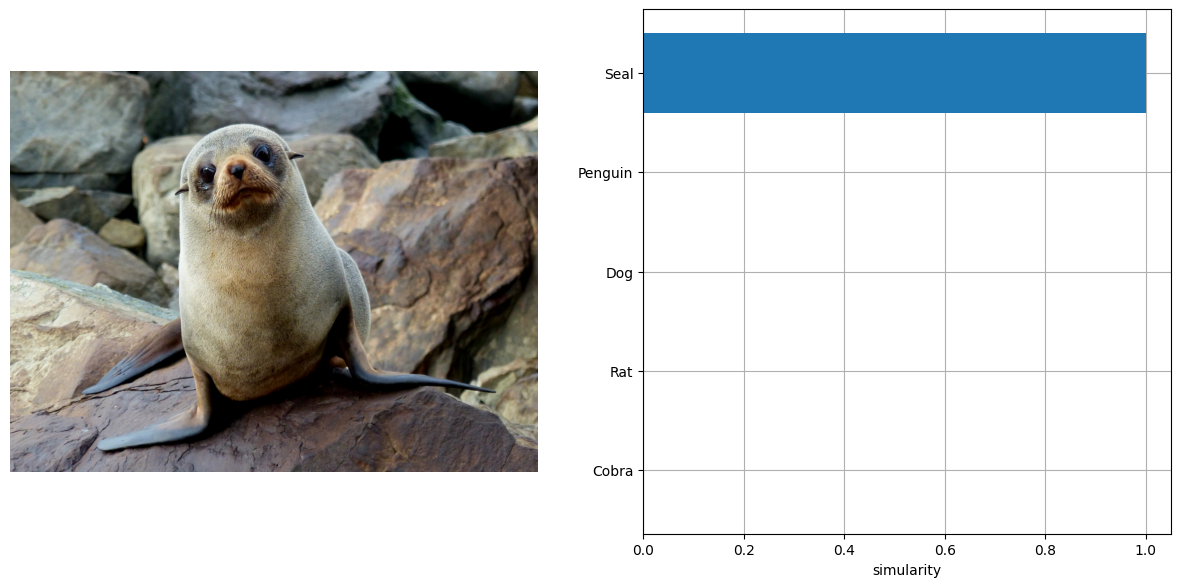

In [6]:
text_embeddings = model.text_model(text_inputs["input_ids"])
image_embeddings = model.vision_model(vision_inputs["pixel_values"])

res = calc_simularity_softmax(image_embeddings.detach().numpy(), text_embeddings.detach().numpy())
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

### Convert Model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). OpenVINO model conversion API should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [7]:
import openvino as ov
from pathlib import Path

core = ov.Core()

In [8]:
fp16_text_model_path = Path("jina-clip-text_v1_fp16.xml")

if not fp16_text_model_path.exists():
    ov_text_model = ov.convert_model(model.text_model, example_input=text_inputs["input_ids"])
    ov.save_model(ov_text_model, fp16_text_model_path)

In [9]:
fp16_vision_model_path = Path("jina-clip-vision_v1_fp16.xml")

if not fp16_vision_model_path.exists():
    ov_vision_model = ov.convert_model(model.vision_model, example_input=vision_inputs["pixel_values"])
    ov.save_model(ov_vision_model, fp16_vision_model_path)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

For starting work, please select inference device from dropdown list.

In [10]:
device = device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Compile model and run inference
[back to top ⬆️](#Table-of-contents:)

In [11]:
compiled_text_model = core.compile_model(fp16_text_model_path, device.value)
compiled_vision_model = core.compile_model(fp16_vision_model_path, device.value)

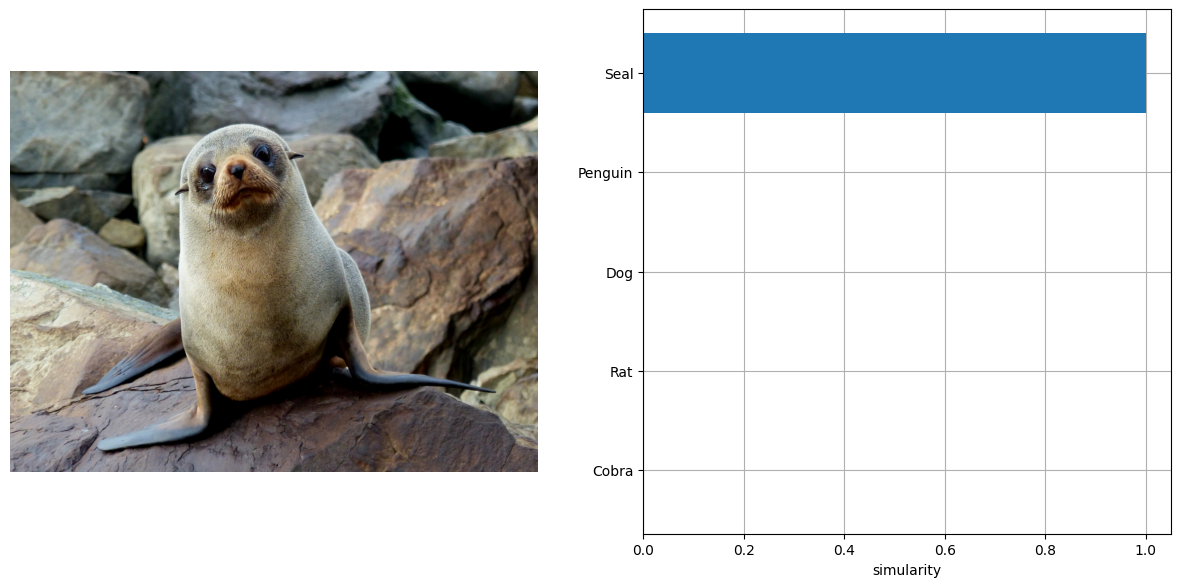

In [12]:
text_ov_res = compiled_text_model(text_inputs["input_ids"])
vis_ov_res = compiled_vision_model(vision_inputs["pixel_values"])

res = calc_simularity_softmax(vis_ov_res[0], text_ov_res[0])
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

## Quantize model to INT8 using NNCF
[back to top ⬆️](#Table-of-contents:)


Lets speed up the model by applying 8-bit post-training quantization from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer quantized model via OpenVINO™ Toolkit. 
[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.
The optimization process contains the following steps:

1. Prepare quantization dataset
2. Quantize the converted OpenVINO model with NNCF with `nncf.quantize()`.
3. Save the `INT8` model using `openvino.save_model()` function.
4. Compare model size of converted and quantized models.
5. Compare performance of converted and quantized models.

> **Note:** quantization process may require additional time and memory for performing. You can disable it using widget below:

In [13]:
to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [14]:
if not Path("skip_kernel_extension.py").exists():
    # Fetch `skip_kernel_extension` module
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

int8_text_model_path = Path("jina-clip-text_v1_int8.xml")
int8_vision_model_path = Path("jina-clip-vision_v1_int8.xml")

%load_ext skip_kernel_extension

### Prepare datasets
[back to top ⬆️](#Table-of-contents:)

The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions is used to quantize model.

#### Dataset with text data
[back to top ⬆️](#Table-of-contents:)

In [15]:
%%skip not $to_quantize.value

import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import requests
from io import BytesIO
import numpy as np
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False


def collate_fn_text(example, text_column="caption"):
    """
    Preprocesses an example by loading and transforming text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    text_input = tokenizer(
        example[text_column],
        return_tensors='pt',
        **tokenizer_kwargs)

    return text_input


def prepare_calibration_data_text(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} samples for the initialization...")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(batch["input_ids"].to("cpu"))
    return data

In [16]:
%%skip not $to_quantize.value

import logging
import nncf

if not int8_text_model_path.exists():
    dataset = load_dataset("google-research-datasets/conceptual_captions", trust_remote_code=True)
    train_dataset = dataset["train"].shuffle(seed=42)

    dataloader_text = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn_text, batch_size=1)
    calibration_data_text = prepare_calibration_data_text(dataloader_text, 50)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino
Fetching 50 samples for the initialization...


  0%|          | 0/50 [00:00<?, ?it/s]

#### Dataset with image data
[back to top ⬆️](#Table-of-contents:)

In [17]:
%%skip not $to_quantize.value


def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")


def collate_fn_vision(example, image_column="image_url"):
    """
    Preprocesses an example by loading and transforming image data.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        h, w = image.size
        if h == 1 or w == 1:
            return None
    except Exception:
        return None

    vision_input = processor(images=[image])
    return vision_input


def prepare_calibration_data_vis(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} samples for the initialization...")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(batch["pixel_values"].to("cpu"))
    return data

In [18]:
%%skip not $to_quantize.value

if not int8_vision_model_path.exists():
    dataset = load_dataset("google-research-datasets/conceptual_captions", trust_remote_code=True)
    train_dataset = dataset["train"].shuffle(seed=42)

    dataloader_vis = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn_vision, batch_size=1)
    calibration_data_vision = prepare_calibration_data_vis(dataloader_vis, 250)

Fetching 250 samples for the initialization...


  0%|          | 0/250 [00:00<?, ?it/s]

### Perform quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained `FP16` model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

#### Quantization of text model
[back to top ⬆️](#Table-of-contents:)

In [20]:
%%skip not $to_quantize.value

if not int8_text_model_path.exists():
    if len(calibration_data_text) == 0:
        raise RuntimeError(
            'Calibration dataset is empty. Please check your internet connection and try to download images manually.'
        )

    ov_model_text = core.read_model(fp16_text_model_path)

    calibration_dataset = nncf.Dataset(calibration_data_text)
    quantized_model = nncf.quantize(
        model=ov_model_text,
        calibration_dataset=calibration_dataset,
        subset_size=50,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alphas=nncf.AdvancedSmoothQuantParameters(matmul=0.6))
    )
    ov.save_model(quantized_model, int8_text_model_path)

Output()

Output()

Output()

Output()

#### Quantization of image model
[back to top ⬆️](#Table-of-contents:)

In [21]:
%%skip not $to_quantize.value

if not int8_vision_model_path.exists():
    if len(calibration_data_vision) == 0:
        raise RuntimeError(
            'Calibration dataset is empty. Please check internet connection and try to download images manually.'
        )

    ov_model_vision = core.read_model(fp16_vision_model_path)

    calibration_dataset = nncf.Dataset(calibration_data_vision)
    quantized_model = nncf.quantize(
        model=ov_model_vision,
        calibration_dataset=calibration_dataset,
        subset_size=250,
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alphas=nncf.AdvancedSmoothQuantParameters(matmul=0.6))
    )
    ov.save_model(quantized_model, int8_vision_model_path)

Output()

Output()

Output()

Output()

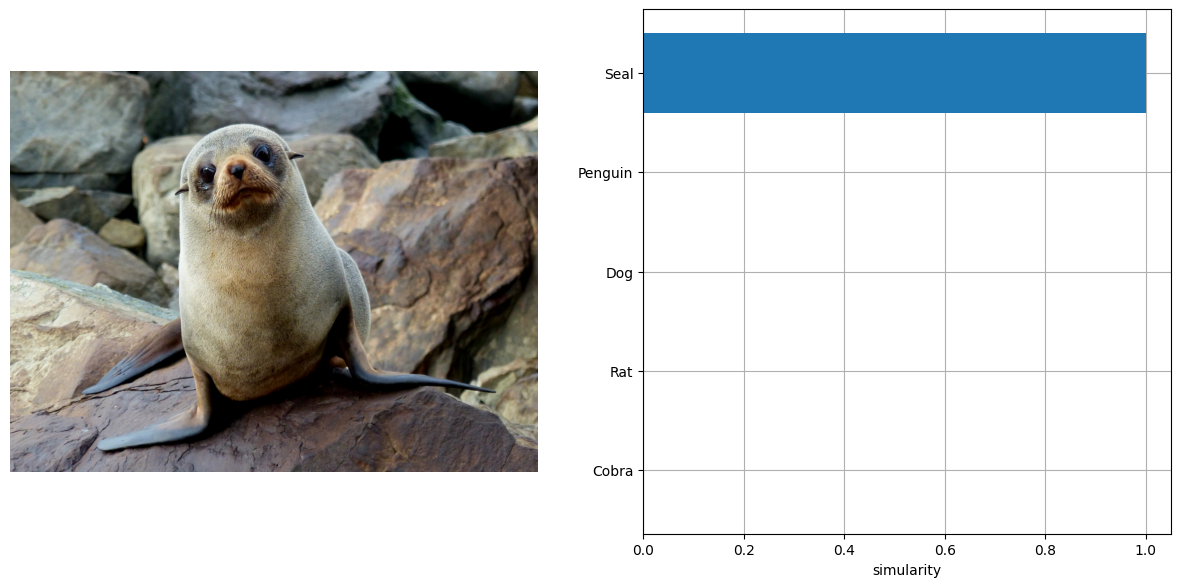

In [22]:
%%skip not $to_quantize.value

compiled_text_model_int8 = core.compile_model(int8_text_model_path, device.value)
compiled_vision_model_int8 = core.compile_model(int8_vision_model_path, device.value)

text_ov_res_int8 = compiled_text_model_int8(text_inputs["input_ids"])
vis_ov_res_int8 = compiled_vision_model_int8(vision_inputs["pixel_values"])

res = calc_simularity_softmax(vis_ov_res_int8[0], text_ov_res_int8[0])
visionize_result(img_furseal, TEXT_INPUTS, np.array(res[0]))

### Compare File Size
[back to top ⬆️](#Table-of-contents:)

In [23]:
%%skip not $to_quantize.value

from pathlib import Path

fp16_ir_model_size = Path(fp16_text_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_text_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(
    f"Text model:   FP16 model size - {fp16_ir_model_size:.2f} MB; INT8 model size - {quantized_model_size:.2f} MB; Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}"
)


fp16_ir_model_size = Path(fp16_vision_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_vision_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(
    f"Vision model: FP16 model size - {fp16_ir_model_size:.2f} MB; INT8 model size - {quantized_model_size:.2f} MB;  Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}"
)

Text model:   FP16 model size - 266.88 MB; INT8 model size - 137.34 MB; Model compression rate: 1.943
Vision model: FP16 model size - 163.83 MB; INT8 model size - 82.83 MB;  Model compression rate: 1.978


### Compare inference time of the FP16 IR and quantized models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [24]:
%%skip not $to_quantize.value

import time


def calculate_inference_time(model_path, calibration_data):
    model = core.compile_model(model_path, device.value)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [25]:
%%skip not $to_quantize.value

fp16_latency = calculate_inference_time(fp16_text_model_path, calibration_data_text)
int8_latency = calculate_inference_time(int8_text_model_path, calibration_data_text)
print(f"Performance speed up for text model: {fp16_latency / int8_latency:.3f}")


fp16_latency = calculate_inference_time(fp16_vision_model_path, calibration_data_vision)
int8_latency = calculate_inference_time(int8_vision_model_path, calibration_data_vision)
print(f"Performance speed up for vision model: {fp16_latency / int8_latency:.3f}")

Performance speed up for text model: 1.424
Performance speed up for vision model: 1.390


## Gradio demo
[back to top ⬆️](#Table-of-contents:)


You can provide your own image and comma-separated list of labels for zero-shot classification.

Feel free to upload an image, using the file upload window and type label names into the text field, using comma as the separator (for example, `cat,dog,bird`)

In [26]:
core = ov.Core()

compiled_text_model_int8 = None
compiled_vision_model_int8 = None
if Path(int8_text_model_path).exists() and Path(int8_vision_model_path).exists():
    compiled_text_model_int8 = core.compile_model(int8_text_model_path, device.value)
    compiled_vision_model_int8 = core.compile_model(int8_vision_model_path, device.value)

compiled_text_model_f16 = core.compile_model(fp16_text_model_path, device.value)
compiled_vision_model_f16 = core.compile_model(fp16_vision_model_path, device.value)


def image_text_sim(text, image, quantized_model):
    compiled_text_model = compiled_text_model_int8 if quantized_model else compiled_text_model_f16
    text = text.split(",")
    text_inputs = tokenizer(text, return_tensors="pt", **tokenizer_kwargs)
    emb1_res = compiled_text_model(text_inputs["input_ids"])

    compiled_vision_model = compiled_vision_model_int8 if quantized_model else compiled_vision_model_f16
    vision_input = processor(images=[image])
    emb2_res = compiled_vision_model(vision_input["pixel_values"])

    text_description = "Simularity: "
    simularity = calc_simularity_softmax(emb2_res[0], emb1_res[0], False)
    if len(text) == 1:
        text_description += f"{simularity[0]}"
    else:
        simularity_text = "\n".join([f"{text[i]} {sim:.4f}" for i, sim in enumerate(simularity[0])])
        text_description += f"\n{simularity_text}"
    return text_description


def text_text_sim(text1, text2, quantized_model):
    compiled_text_model = compiled_text_model_int8 if quantized_model else compiled_text_model_f16

    text_inputs = tokenizer(text1, return_tensors="pt", **tokenizer_kwargs)
    emb1_res = compiled_text_model(text_inputs["input_ids"])

    text_inputs = tokenizer(text2, return_tensors="pt", **tokenizer_kwargs)
    emb2_res = compiled_text_model(text_inputs["input_ids"])

    return f"Simularity: {calc_simularity_softmax(emb1_res[0], emb2_res[0], False)[0][0]:.4f}"


def image_image_sim(image1, image2, quantized_model):
    compiled_vision_model = compiled_vision_model_int8 if quantized_model else compiled_vision_model_f16

    vision_input = processor(images=[image1])
    emb1_res = compiled_vision_model(vision_input["pixel_values"])

    vision_input = processor(images=[image2])
    emb2_res = compiled_vision_model(vision_input["pixel_values"])

    return f"Simularity: {calc_simularity_softmax(emb1_res[0], emb2_res[0], False)[0][0]:.4f}"

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/jina-clip/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

model_choice_visible = Path(int8_text_model_path).exists() and Path(int8_vision_model_path).exists()

demo = make_demo(image_text_fn=image_text_sim, text_text_fn=text_text_sim, image_image_fn=image_image_sim, model_choice_visible=model_choice_visible)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/